## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import random
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.is_gpu_available():
    print("TensorFlow can use the GPU!")

Num GPUs Available:  1
TensorFlow can use the GPU!


## Dataset Info

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input/ukraine-ml-bootcamp-2023'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename.endswith('.jpg'):
            print('...')
            break

/kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv
/kaggle/input/ukraine-ml-bootcamp-2023/train.csv
/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/1684a6b47dd92daca9b0803d18f1285a.jpg
...
/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/07620090bd3581a0c7c344750f18621b.jpg
...


In [4]:
base_dir='/kaggle/input/ukraine-ml-bootcamp-2023/'

df = pd.read_csv(base_dir + 'train.csv')
df.head(5)

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


In [5]:
df.shape

(2360, 2)

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

image_id    0
class_6     0
dtype: int64

In [8]:
df['class_6'].value_counts()

class_6
4    603
0    505
1    489
2    310
5    260
3    193
Name: count, dtype: int64

## Class Samples

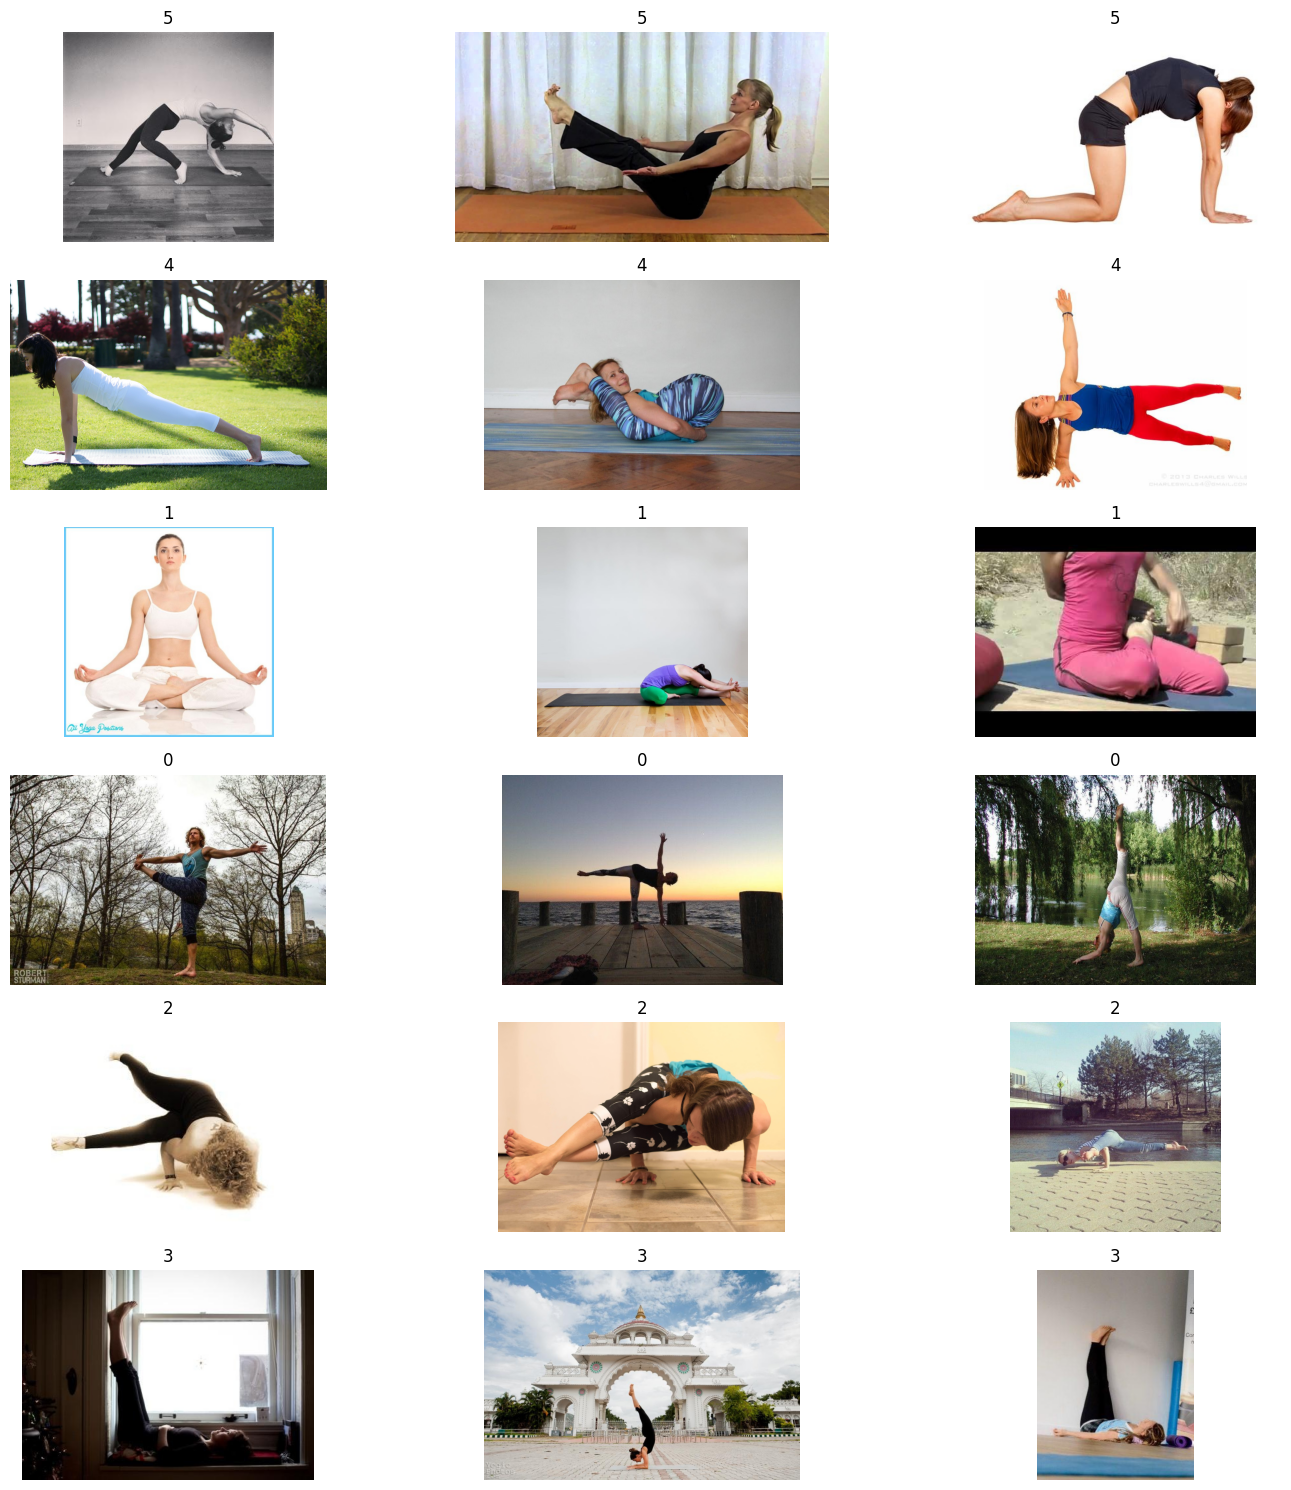

In [9]:
plt.figure(figsize=(15, 15))

unique_classes = df['class_6'].unique()

for i, class_name in enumerate(unique_classes):
    image_files = df[df['class_6'] == class_name]['image_id'].tolist()
    random.shuffle(image_files)  # Shuffle the list of image files for randomness
    random_image_files = image_files[:3]  # Select the first three random images
    for j, random_image_file in enumerate(random_image_files):
        image_path = os.path.join(base_dir, 'images/train_images/', random_image_file)
        img = plt.imread(image_path)
        plt.subplot(len(unique_classes), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

## MoveNet SinglePose detecting

In [10]:
# Download the model from TF Hub.
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

# Process image and extract pose keypoints.
def process_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image)
        image = tf.image.resize_with_pad(image, target_height=256, target_width=256)
        image = tf.expand_dims(image, axis=0)
        image = tf.cast(image, dtype=tf.int32)
    
        # Run model inference.
        pose = movenet(image)

        return pose['output_0'].numpy()[0, 0]
    except Exception as e:
        print(f"Error processing: {image_path}")
        #print(e)  # debugging.
        return np.zeros((17, 3))

# Apply the process_image function to each image_id and store the results in a new column.
df['pose_keypoints'] = df['image_id'].apply(lambda x: process_image(os.path.join(base_dir, 'images/train_images/', x)))

df.head(5)

Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/b28b07ddca7aec463cb8dec49a2b93c3.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/1ceabd67b1a4253440e82e9d6650378f.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/5de3eb74884ccbb2d3dfdf57a4527380.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/63afe64ccfa6f2beb6500e467ab216e7.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/6d62f51bb328d2b8b3a99593383fcb65.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/78fc37ee169f8d8765881f321564b12d.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/38f686ad5a5513c479678587f561cc19.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/c189e4f553b4647e0753eb20c9e8053b.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/0ad7a79378e

,image_id,class_6,pose_keypoints
0,1daf45401342ac321c0aa5668f51d004.jpg,5,"[[0.5937422, 0.34236047, 0.49792072], [0.60195..."
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4,"[[0.4141406, 0.6915319, 0.5964384], [0.4465576..."
2,1dc97053cf67cb8e51c983abb0021083.jpg,4,"[[0.6233182, 0.10214917, 0.6252054], [0.598038..."
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1,"[[0.26520362, 0.357475, 0.6867965], [0.2380825..."
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0,"[[0.540565, 0.6909688, 0.70915353], [0.5259958..."


## Samples pose joint detection

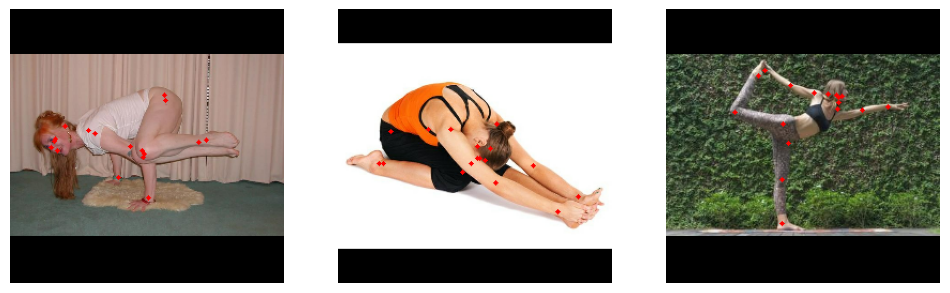

In [11]:
def draw_keypoints(image, keypoints, ax):
    # Convert the TensorFlow tensor to a NumPy array for Matplotlib
    image_np = image.numpy()[0]  # Extract the single image from the batch
    image_np = image_np.astype(np.uint8)
    image_copy = np.copy(image_np)

    for keypoint in keypoints:
        y, x, score = keypoint
        y = int(y * image_copy.shape[0])
        x = int(x * image_copy.shape[1])
        # Draw red circle at each keypoint
        cv2.circle(image_copy, (x, y), 2, (255, 0, 0), -1)

    ax.imshow(image_copy)
    ax.axis('off')

def draw_keypoints_from_df(files_dir, dataFrame):
    # Create a single-row subplot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the figure size as needed

    # Iterate through the first 3 rows of the DataFrame
    for i, (index, row) in enumerate(dataFrame.iterrows()):
        # Load the image
        filename = row['image_id']
        image_path = os.path.join(files_dir, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image)
        image = tf.image.resize_with_pad(image, target_height=256, target_width=256)
        image = tf.expand_dims(image, axis=0)

        keypoints = row['pose_keypoints']

        draw_keypoints(image, keypoints, axs[i])

    plt.show()

draw_keypoints_from_df(base_dir+'images/train_images/', df.sample(n=3))

## Splitting Data

In [12]:
# Convert the data to a NumPy array
X = np.array(df['pose_keypoints'].tolist())
y = np.array(df['class_6'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

## Model Architecture

In [13]:
# Define input/output
num_features = 17 * 3
num_classes = 6
sequence_length = X_train.shape[0]

X_train = X_train.reshape(X_train.shape[0], -1, num_features)
X_val = X_val.reshape(X_val.shape[0], -1, num_features)

# Create a Sequential model
model = Sequential()

# LSTM Layers
model.add(Bidirectional(LSTM(4096, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(None, num_features)))
model.add(Bidirectional(LSTM(2048, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(1024, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(512, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)))

# Dense Layers
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(units=num_classes, activation='softmax'))

## Optimizer and Callbacks

In [14]:
# Optimizer
initial_lr = 1e-4
def lr_schedule(epoch):
    return initial_lr * 0.9 ** epoch

optimizer = Adam(learning_rate=initial_lr)

# Define callbacks
early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a learning rate finder function
def find_lr(epoch, lr):
    return lr * math.pow(0.9, epoch)

# Define a callback to adjust the learning rate
lr_finder = LearningRateScheduler(find_lr)

callbacks = [early_stopping, lr_scheduler, lr_finder]

## Compile Model

In [15]:
# Compiling the Model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 8192)       135921664 
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 4096)       167788544 
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 2048)       41951232  
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 1024)       10489856  
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 512)        2

## Model Training

In [16]:
# Train the model
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    batch_size=72,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
30/30 [==============================] - 35s 405ms/step - loss: 273.1986 - accuracy: 0.5297 - val_loss: 229.9920 - val_accuracy: 0.1314 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 5s 178ms/step - loss: 202.1680 - accuracy: 0.7123 - val_loss: 175.9251 - val_accuracy: 0.1314 - lr: 8.1000e-05
Epoch 3/100
30/30 [==============================] - 5s 178ms/step - loss: 158.0039 - accuracy: 0.7439 - val_loss: 141.7658 - val_accuracy: 0.1314 - lr: 6.5610e-05
Epoch 4/100
30/30 [==============================] - 5s 182ms/step - loss: 129.5898 - accuracy: 0.7702 - val_loss: 119.2239 - val_accuracy: 0.1314 - lr: 5.3144e-05
Epoch 5/100
30/30 [==============================] - 5s 182ms/step - loss: 110.4702 - accuracy: 0.8089 - val_loss: 103.7297 - val_accuracy: 0.1314 - lr: 4.3047e-05
Epoch 6/100
30/30 [==============================] - 5s 184ms/step - loss: 97.1298 - accuracy: 0.8258 - val_loss: 92.7265 - val_accuracy: 0.1314 - lr: 3.4868e-05
Epoch 7/100
30/30

## Training Visualization

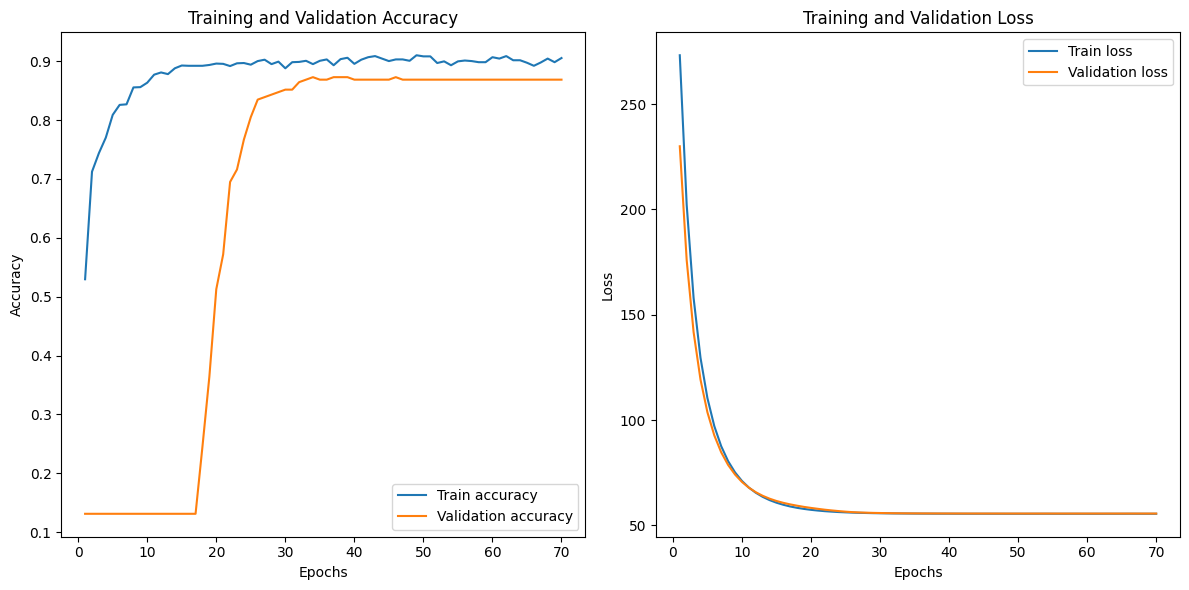

In [17]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    plt.plot(range(1, len(train_metric) + 1), train_metric, label=f'Train {metric}')
    plt.plot(range(1, len(val_metric) + 1), val_metric, label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.legend()

plt.figure(figsize=(12, 6))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plot_metrics(history, 'accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plot_metrics(history, 'loss')

plt.tight_layout()
plt.show()

## Validation Mean F-Score

In [18]:
# Validation
y_true = y_val
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

micro_precision, micro_recall, micro_f1 = (precision_score(y_true, y_pred_classes, average='micro'),
                                           recall_score(y_true, y_pred_classes, average='micro'),
                                           f1_score(y_true, y_pred_classes, average='micro'))

print("Micro Precision: {:.5f}".format(micro_precision))
print("Micro Recall: {:.5f}".format(micro_recall))
print("Micro F1 Score: {:.5f}".format(micro_f1))

f1_scores = f1_score(y_true, y_pred_classes, average=None)
mean_f_score = np.mean(f1_scores)

print("Mean F-Score: {:.5f}".format(mean_f_score))

8/8 [==============================] - 4s 32ms/step
Micro Precision: 0.86864
Micro Recall: 0.86864
Micro F1 Score: 0.86864
Mean F-Score: 0.87910


## Submission for Test images

Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/57c1dee76d7a95c0e9243211a24bd80c.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/01a34d9b6616d060f29ade56eebc6e2c.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/2380de8cf4113d297807a9b314d5066f.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/4270873295a51482cad153c6b053daee.jpg
Error processing: /kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/82de8508dcc79d2811dc7e2a9115d3a6.jpg
24/24 [==============================] - 1s 34ms/step


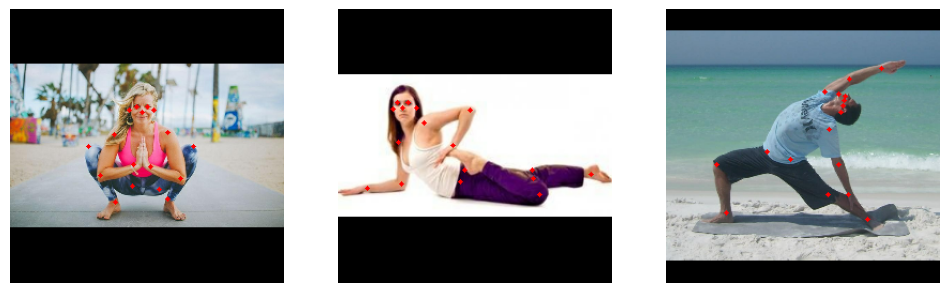

,image_id,class_6
0,07620090bd3581a0c7c344750f18621b.jpg,4
1,277bdc60f20a49d73525ab24a6e2128a.jpg,4
2,798d7ed914181f0f61f1e84de6ae7bab.jpg,1
3,81def953c8ba1b3e084582f11972e135.jpg,4
4,772c257c9a37357eec811b923109fcb4.jpg,0


In [19]:
test_img_dir = base_dir + 'images/test_images/'
filenames = os.listdir(test_img_dir)

test_df = pd.DataFrame({'image_id': filenames})
test_df['pose_keypoints'] = test_df['image_id'].apply(lambda x: process_image(os.path.join(test_img_dir, x)))

X = np.array(test_df['pose_keypoints'].tolist()).reshape(-1, 1, num_features)
test_pred = model.predict(X)
test_pred_classes = np.argmax(test_pred, axis=1)

submission_df = pd.DataFrame({'image_id': test_df['image_id'], 'class_6': test_pred_classes})
submission_df['image_id'] = submission_df['image_id'].apply(lambda x: x.split('/')[-1])

submission_df.to_csv('submission.csv', index=False)

draw_keypoints_from_df(test_img_dir, test_df.sample(n=3))
submission_df.head(5)